In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [53]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [54]:
t_steps = 200
num_demos = 100
num_val = 20
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(int(num_demos/2), 1)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0)
y0 = torch.unsqueeze(torch.sin(x*torch.pi) + noise, 2)

y1 = 1-y0

x = torch.unsqueeze(x.repeat(2,1), 2)
y = torch.cat((y0, y1), 0)
print("X:", x.shape, "Y:", y.shape)

path = "."

#######################################

vx = torch.linspace(0, 1, t_steps).repeat(int(num_val/2), 1)
vnoise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0)
vy0 = torch.unsqueeze(torch.sin(vx*torch.pi) + vnoise, 2)
vy1 = 1-vy0

vx = torch.unsqueeze(vx.repeat(2,1), 2)
vy = torch.cat((vy0, vy1), 0)

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1])


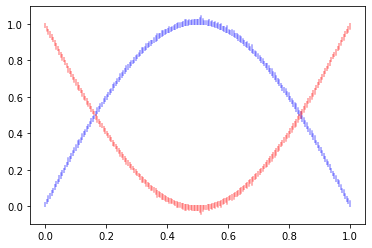

In [55]:
plt.plot(x[:50, :, 0], y[:50, :, 0], 'b', alpha=0.3)
plt.plot(x[51:, :, 0], y[51:, :, 0], 'r', alpha=0.3)
plt.show()

In [56]:
n_max = 6

def sample_training_demonstration():    
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.unsqueeze(torch.Tensor(x[rand_traj_ind, observation_indices[-1], :]), 0)
    targetY = torch.unsqueeze(torch.Tensor(rand_traj[observation_indices[-1], :]), 0)
    
    if device.type == 'cuda':
        return observations.float().cuda(), targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), targetX.float(), targetY.float()


def get_validation_demonstration(ind):
    x = vx[ind, :, :]
    y = vy[ind, :, :]
    
    if device.type == 'cuda':
        return x.float().cuda(), y.float().cuda()
    else:
        return x, y

In [59]:
class BCNP(nn.Module):
    def __init__(self, in_shape):
        super(BCNP, self).__init__()
        
        dx, dy = in_shape[0], in_shape[1]
        
        dz = 128
        dzt = dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dz)
        )
        
        self.f0 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )

        self.f1 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )
        

    def forward(self, observations, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)

        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        z_target = torch.cat((zs, target), 1)
        
        return self.f0(z_target), self.f1(z_target)


def log_prob_loss(ty, ty_pred):
    m, s = ty_pred.chunk(2, dim = -1)
    s = F.softplus(s)
    dist = D.Independent(D.Normal(loc=m, scale=s), 1)
    return -torch.mean(dist.log_prob(ty))


def plot_trajs(path, i, x, y, pt, col):    
    plt.plot(x, y, 'k', alpha=0.5)
    plt.plot(x, pt[:, 0], col, alpha=0.75)
    plt.savefig(path+str(i)+'.png')    
    plt.close()


def validate(plot=False, path='', it=-1):
    verr=torch.zeros(num_val)
    
    with torch.no_grad():
        for i in range(num_val):
            val_x, val_y = get_validation_demonstration(i)

            cond_step = 0
            observation = torch.Tensor([val_y[cond_step, :], val_x[cond_step, :]]).view(1, dx+dy).float().cuda()
            
            pred_traj0, pred_traj1 = torch.zeros_like(val_y), torch.zeros_like(val_y)
            pred_traj0[cond_step, :] = val_y[cond_step, :]
            pred_traj1[cond_step, :] = val_y[cond_step, :]

            for t in range(1, t_steps):
                pred0, pred1 = model(observation, torch.unsqueeze(val_x[t], 0))
                pred_traj0[t, :], _ = pred0.chunk(2, dim = -1)  # pred[0]: mean, pred[1]: std
                pred_traj1[t, :], _ = pred1.chunk(2, dim = -1)
            
            verr0, verr1 = torch.sum((val_y - pred_traj0) ** 2), torch.sum((val_y - pred_traj1) ** 2)
#             print(f'v0: {verr0}\nv1: {verr1}')
            if verr0 < verr1:
                verr[i] = verr0
                if plot:
                    plot_trajs(path, i, val_x.cpu(), val_y.cpu(), pred_traj0.cpu(), 'r')
            else:
                verr[i] = verr1
                if plot:
                    plot_trajs(path, i, val_x.cpu(), val_y.cpu(), pred_traj1.cpu(), 'b')
            
    return torch.mean(verr)

In [61]:
root_path = f'val/{int(time.time())}'

model = BCNP((1, 1))
model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

val_after_iter = 2500
plot_after_iter = 250000
iters = 10000000

losses = []
min_verr = 1e6

for i in range(iters):
    obss, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds = model(obss, tx)
    loss0, loss1 = log_prob_loss(ty, ty_preds[0]), log_prob_loss(ty, ty_preds[1])
    
    if loss0 < loss1 == 0:
        model.f0.requires_grad = True
        model.f1.requires_grad = False
#         loss = loss0.data
        loss0.backward()
    else:
        model.f0.requires_grad = False
        model.f1.requires_grad = True
#         loss = loss1.data
        loss1.backward()
    
    optimizer.step()
#     if i%500 == 0:
#         print(f'{i}: {loss}')
    
    if i%val_after_iter == 0:
        if i%plot_after_iter == 0:
            d_path = f'{root_path}/{str(i)}/'
            try:
                os.makedirs(d_path)
            except:
                pass
            verr = validate(True, d_path, i)
        else:
            verr = validate()
        print(f"{i}: {verr}")
        losses.append(verr)

        if verr < min_verr:
            min_verr = verr
            print(f"Best validation")
            torch.save(model.state_dict(), f'{path}/best_model.pt')

v0: 98.17557525634766
v1: 91.24116516113281

v0: 98.36859893798828
v1: 91.42778015136719

v0: 98.42971801757812
v1: 91.48094177246094

v0: 98.41683197021484
v1: 91.47868347167969

v0: 98.16284942626953
v1: 91.23419952392578

v0: 98.02685546875
v1: 91.10125732421875

v0: 98.45255279541016
v1: 91.50636291503906

v0: 98.32255554199219
v1: 91.38407897949219

v0: 98.38536071777344
v1: 91.4478759765625

v0: 98.23307037353516
v1: 91.297607421875

v0: 42.325439453125
v1: 38.9296875

v0: 42.28415298461914
v1: 38.894439697265625

v0: 42.421470642089844
v1: 39.00237274169922

v0: 42.433502197265625
v1: 39.041316986083984

v0: 42.527618408203125
v1: 39.11833953857422

v0: 42.48499298095703
v1: 39.0810661315918

v0: 42.222225189208984
v1: 38.832244873046875

v0: 42.35667419433594
v1: 38.96281051635742

v0: 42.453208923339844
v1: 39.05038833618164

v0: 42.351009368896484
v1: 38.95627212524414

0: 65.1734390258789
Best validation
v0: 94.5512924194336
v1: 29.958763122558594

v0: 94.74077606201172
v1: 

v0: 43.114227294921875
v1: 18.201648712158203

v0: 42.845611572265625
v1: 18.204967498779297

v0: 42.98412322998047
v1: 18.249298095703125

v0: 43.0726203918457
v1: 18.223987579345703

v0: 42.97869873046875
v1: 18.236064910888672

20000: 15.087946891784668
Best validation
v0: 96.34268188476562
v1: 12.131098747253418

v0: 96.53404998779297
v1: 12.114023208618164

v0: 96.6670913696289
v1: 12.015973091125488

v0: 96.58334350585938
v1: 12.19586181640625

v0: 96.36042785644531
v1: 12.088059425354004

v0: 96.19657897949219
v1: 12.163688659667969

v0: 96.6324462890625
v1: 12.106026649475098

v0: 96.49995422363281
v1: 12.145849227905273

v0: 96.57913208007812
v1: 12.130243301391602

v0: 96.39999389648438
v1: 12.154972076416016

v0: 42.97842788696289
v1: 6.908117294311523

v0: 42.93598175048828
v1: 6.9056806564331055

v0: 43.05744934082031
v1: 6.861415386199951

v0: 43.085636138916016
v1: 6.9745025634765625

v0: 43.177093505859375
v1: 6.890625

v0: 43.139530181884766
v1: 6.939088344573975

v0: 

v0: 96.82157897949219
v1: 2.520287036895752

v0: 96.63993835449219
v1: 2.4553704261779785

v0: 43.23292922973633
v1: 0.08078008890151978

v0: 43.19015884399414
v1: 0.08454959094524384

v0: 43.33674621582031
v1: 0.09519626200199127

v0: 43.34008026123047
v1: 0.08901649713516235

v0: 43.44200134277344
v1: 0.08173640072345734

v0: 43.39458084106445
v1: 0.07506825029850006

v0: 43.1302604675293
v1: 0.08795036375522614

v0: 43.26597213745117
v1: 0.08082584291696548

v0: 43.36257553100586
v1: 0.08538886904716492

v0: 43.25830078125
v1: 0.07964396476745605

42500: 1.2846224308013916
v0: 97.02946472167969
v1: 1.4313193559646606

v0: 97.22146606445312
v1: 1.4433398246765137

v0: 97.36752319335938
v1: 1.6414788961410522

v0: 97.2701416015625
v1: 1.4556162357330322

v0: 97.05217742919922
v1: 1.4855470657348633

v0: 96.88219451904297
v1: 1.4164973497390747

v0: 97.32405090332031
v1: 1.5082701444625854

v0: 97.18695831298828
v1: 1.4614059925079346

v0: 97.2722396850586
v1: 1.503374457359314

v0: 97

v0: 97.29086303710938
v1: 0.37869131565093994

v0: 97.48306274414062
v1: 0.39157307147979736

v0: 97.63436889648438
v1: 0.5059192180633545

v0: 97.53169250488281
v1: 0.39425724744796753

v0: 97.31468200683594
v1: 0.4112202823162079

v0: 97.14334106445312
v1: 0.3747420907020569

v0: 97.58889770507812
v1: 0.4136396646499634

v0: 97.447509765625
v1: 0.39914706349372864

v0: 97.53297424316406
v1: 0.42283767461776733

v0: 97.3482437133789
v1: 0.38235676288604736

v0: 43.44243240356445
v1: 0.31082528829574585

v0: 43.39934158325195
v1: 0.3048071265220642

v0: 43.54010772705078
v1: 0.29048871994018555

v0: 43.549339294433594
v1: 0.30189481377601624

v0: 43.65011215209961
v1: 0.3103428781032562

v0: 43.604583740234375
v1: 0.3197229504585266

v0: 43.337730407714844
v1: 0.2911369204521179

v0: 43.4736442565918
v1: 0.30237877368927

v0: 43.570091247558594
v1: 0.29586300253868103

v0: 43.46773147583008
v1: 0.305707722902298

65000: 0.3553776144981384
v0: 97.07797241210938
v1: 0.26540133357048035



v0: 43.538448333740234
v1: 0.09159499406814575

v0: 43.67472457885742
v1: 0.09408649802207947

v0: 43.77278137207031
v1: 0.09708589315414429

v0: 43.66740798950195
v1: 0.09022147953510284

85000: 0.4217531681060791
v0: 97.40760803222656
v1: 0.32197368144989014

v0: 97.60000610351562
v1: 0.31489574909210205

v0: 97.72076416015625
v1: 0.31016987562179565

v0: 97.6485595703125
v1: 0.3253670334815979

v0: 97.41777801513672
v1: 0.32975417375564575

v0: 97.25993347167969
v1: 0.33220914006233215

v0: 97.69578552246094
v1: 0.3089117705821991

v0: 97.56085968017578
v1: 0.3203169107437134

v0: 97.63644409179688
v1: 0.3190661072731018

v0: 97.46499633789062
v1: 0.3234703242778778

v0: 43.60472106933594
v1: 0.3651081919670105

v0: 43.56131362915039
v1: 0.37052053213119507

v0: 43.7138557434082
v1: 0.4150041937828064

v0: 43.71145248413086
v1: 0.3713601231575012

v0: 43.81725311279297
v1: 0.3673080801963806

v0: 43.7672233581543
v1: 0.35508692264556885

v0: 43.50245666503906
v1: 0.3878592252731323


v0: 97.51316833496094
v1: 0.04023319482803345

v0: 97.33992004394531
v1: 0.04334960877895355

v0: 43.69355773925781
v1: 0.21342305839061737

v0: 43.649940490722656
v1: 0.21580052375793457

v0: 43.801673889160156
v1: 0.23811711370944977

v0: 43.80008316040039
v1: 0.21539781987667084

v0: 43.905357360839844
v1: 0.2077072560787201

v0: 43.85628128051758
v1: 0.20243893563747406

v0: 43.590919494628906
v1: 0.22677797079086304

v0: 43.726890563964844
v1: 0.21634405851364136

v0: 43.824928283691406
v1: 0.22044362127780914

v0: 43.718727111816406
v1: 0.21138088405132294

107500: 0.13058049976825714
v0: 97.13079833984375
v1: 0.42329299449920654

v0: 97.32255554199219
v1: 0.43563205003738403

v0: 97.43832397460938
v1: 0.5199776291847229

v0: 97.37129211425781
v1: 0.4398789405822754

v0: 97.136474609375
v1: 0.4414905309677124

v0: 96.98342895507812
v1: 0.41403821110725403

v0: 97.41650390625
v1: 0.4596555233001709

v0: 97.28225708007812
v1: 0.4397028684616089

v0: 97.35740661621094
v1: 0.45520633

v0: 43.607608795166016
v1: 0.02850409597158432

127500: 0.09243795275688171
v0: 97.15689086914062
v1: 0.14779245853424072

v0: 97.3486328125
v1: 0.1530245840549469

v0: 97.46475219726562
v1: 0.2456834614276886

v0: 97.39738464355469
v1: 0.15936774015426636

v0: 97.16581726074219
v1: 0.16957294940948486

v0: 97.009521484375
v1: 0.14161905646324158

v0: 97.44541931152344
v1: 0.17604859173297882

v0: 97.30917358398438
v1: 0.16028763353824615

v0: 97.38572692871094
v1: 0.1789797991514206

v0: 97.21424865722656
v1: 0.14876917004585266

v0: 43.57658004760742
v1: 0.06747971475124359

v0: 43.533138275146484
v1: 0.06083519756793976

v0: 43.68537521362305
v1: 0.07323240488767624

v0: 43.683250427246094
v1: 0.06826911866664886

v0: 43.787906646728516
v1: 0.06764721870422363

v0: 43.73903274536133
v1: 0.06995926797389984

v0: 43.47397994995117
v1: 0.0655602440237999

v0: 43.608760833740234
v1: 0.06837170571088791

v0: 43.70793533325195
v1: 0.07109039276838303

v0: 43.6018180847168
v1: 0.0671153515

v0: 43.58324432373047
v1: 0.017494969069957733

v0: 43.53978729248047
v1: 0.021443860605359077

v0: 43.6886100769043
v1: 0.01796666346490383

v0: 43.68988037109375
v1: 0.020484039559960365

v0: 43.79322814941406
v1: 0.01677500456571579

v0: 43.74571990966797
v1: 0.014953105710446835

v0: 43.47957992553711
v1: 0.019452542066574097

v0: 43.616024017333984
v1: 0.01828906685113907

v0: 43.71311569213867
v1: 0.0177160631865263

v0: 43.60846710205078
v1: 0.016038481146097183

150000: 0.0429675430059433
v0: 97.1001205444336
v1: 0.09741662442684174

v0: 97.2918701171875
v1: 0.09088263660669327

v0: 97.41206359863281
v1: 0.10175566375255585

v0: 97.34066772460938
v1: 0.0929419994354248

v0: 97.10885620117188
v1: 0.0901084691286087

v0: 96.95285034179688
v1: 0.09637820720672607

v0: 97.3858642578125
v1: 0.0934613049030304

v0: 97.25177001953125
v1: 0.09405370056629181

v0: 97.32907104492188
v1: 0.09269247204065323

v0: 97.15746307373047
v1: 0.09352891147136688

v0: 43.56898498535156
v1: 0.018697

v0: 96.96454620361328
v1: 0.07179379463195801

v0: 97.15625
v1: 0.07324840128421783

v0: 97.26457977294922
v1: 0.1095765233039856

v0: 97.20504760742188
v1: 0.07539314031600952

v0: 96.97199249267578
v1: 0.07839648425579071

v0: 96.81741333007812
v1: 0.07136712968349457

v0: 97.25141906738281
v1: 0.07886216789484024

v0: 97.11734008789062
v1: 0.07713913917541504

v0: 97.19315338134766
v1: 0.08336490392684937

v0: 97.0218505859375
v1: 0.07091494649648666

v0: 43.62074279785156
v1: 0.03303815796971321

v0: 43.5771598815918
v1: 0.0368431955575943

v0: 43.73038101196289
v1: 0.03261147812008858

v0: 43.727325439453125
v1: 0.034754782915115356

v0: 43.83222579956055
v1: 0.030000876635313034

v0: 43.78329849243164
v1: 0.028223097324371338

v0: 43.51826477050781
v1: 0.0340360552072525

v0: 43.65263748168945
v1: 0.03238729387521744

v0: 43.75190734863281
v1: 0.03217509388923645

v0: 43.645973205566406
v1: 0.030457720160484314

172500: 0.0557292103767395
v0: 97.01365661621094
v1: 0.0784632414579

v0: 43.72739028930664
v1: 0.13886789977550507

v0: 43.68361282348633
v1: 0.14857354760169983

v0: 43.830596923828125
v1: 0.15941482782363892

v0: 43.83384704589844
v1: 0.14841514825820923

v0: 43.936370849609375
v1: 0.14051327109336853

v0: 43.89016342163086
v1: 0.13101300597190857

v0: 43.62273406982422
v1: 0.15272867679595947

v0: 43.75899887084961
v1: 0.14495450258255005

v0: 43.856201171875
v1: 0.15016812086105347

v0: 43.75257873535156
v1: 0.13907642662525177

192500: 0.10759367048740387
v0: 96.93876647949219
v1: 0.09882903844118118

v0: 97.13035583496094
v1: 0.10783900320529938

v0: 97.21754455566406
v1: 0.13267819583415985

v0: 97.1791763305664
v1: 0.10329630970954895

v0: 96.93760681152344
v1: 0.10390884429216385

v0: 96.79165649414062
v1: 0.09186644107103348

v0: 97.21981048583984
v1: 0.11273641139268875

v0: 97.08865356445312
v1: 0.10210032016038895

v0: 97.1591796875
v1: 0.10227634012699127

v0: 96.99607849121094
v1: 0.09812545776367188

v0: 43.61493682861328
v1: 0.035422436

v0: 97.08938598632812
v1: 0.07368312776088715

v0: 97.2811279296875
v1: 0.0707162469625473

v0: 97.36660766601562
v1: 0.05740068107843399

v0: 97.32991790771484
v1: 0.07169152051210403

v0: 97.0897216796875
v1: 0.06728802621364594

v0: 96.94212341308594
v1: 0.07578149437904358

v0: 97.37232971191406
v1: 0.06531831622123718

v0: 97.240234375
v1: 0.06966318190097809

v0: 97.31019592285156
v1: 0.06268171966075897

v0: 97.14674377441406
v1: 0.07167311757802963

v0: 43.55864334106445
v1: 0.019280172884464264

v0: 43.5151252746582
v1: 0.018944870680570602

v0: 43.664337158203125
v1: 0.022146806120872498

v0: 43.66523742675781
v1: 0.020194416865706444

v0: 43.76897048950195
v1: 0.01735440269112587

v0: 43.721046447753906
v1: 0.01801600120961666

v0: 43.45484924316406
v1: 0.021410387009382248

v0: 43.591487884521484
v1: 0.02052265964448452

v0: 43.688575744628906
v1: 0.01775139570236206

v0: 43.583858489990234
v1: 0.019290700554847717

215000: 0.044040463864803314
v0: 97.18875885009766
v1: 0.0

v0: 43.81721878051758
v1: 0.027436766773462296

v0: 43.817970275878906
v1: 0.025044618174433708

v0: 43.921730041503906
v1: 0.024942409247159958

v0: 43.874271392822266
v1: 0.026567935943603516

v0: 43.60820007324219
v1: 0.02779688872396946

v0: 43.743408203125
v1: 0.027367468923330307

v0: 43.841835021972656
v1: 0.024541102349758148

v0: 43.73672103881836
v1: 0.02644503489136696

235000: 0.16050800681114197
v0: 97.0572738647461
v1: 0.1185760498046875

v0: 97.2490234375
v1: 0.11393103003501892

v0: 97.32527923583984
v1: 0.10531353950500488

v0: 97.29777526855469
v1: 0.11530598998069763

v0: 97.05055236816406
v1: 0.11208628118038177

v0: 96.9100341796875
v1: 0.12114988267421722

v0: 97.33647155761719
v1: 0.11316081136465073

v0: 97.20406341552734
v1: 0.11413469910621643

v0: 97.2715835571289
v1: 0.10586512088775635

v0: 97.11459350585938
v1: 0.11701954156160355

v0: 43.82215118408203
v1: 0.033136628568172455

v0: 43.77818298339844
v1: 0.03759535402059555

v0: 43.92987060546875
v1: 0.032

v0: 96.84942626953125
v1: 0.12934847176074982

v0: 96.7102279663086
v1: 0.10296601057052612

v0: 97.13221740722656
v1: 0.13475188612937927

v0: 97.00601959228516
v1: 0.11751342564821243

v0: 97.06861877441406
v1: 0.1338120400905609

v0: 96.91451263427734
v1: 0.1103401929140091

v0: 43.82359313964844
v1: 0.01773415133357048

v0: 43.77960205078125
v1: 0.016021303832530975

v0: 43.926815032958984
v1: 0.014573155902326107

v0: 43.929931640625
v1: 0.01709838956594467

v0: 44.032752990722656
v1: 0.014222181402146816

v0: 43.98657989501953
v1: 0.016425684094429016

v0: 43.71916580200195
v1: 0.017625246196985245

v0: 43.85509490966797
v1: 0.01696917600929737

v0: 43.95287322998047
v1: 0.014633667655289173

v0: 43.84876251220703
v1: 0.01674586907029152

257500: 0.07130187004804611
v0: 96.85918426513672
v1: 0.06105523556470871

v0: 97.05078125
v1: 0.0556844100356102

v0: 97.12602233886719
v1: 0.05803455039858818

v0: 97.09966278076172
v1: 0.058445047587156296

v0: 96.8533935546875
v1: 0.05750993

KeyboardInterrupt: 